In [98]:
import os
import pandas as pd
import pickle
import numpy as np

from torch import load

In [13]:
def merge_pickled_dictionaries(main_folder_path, protein):
    i = 0
    merged_dict = {}
    for root, dirs, files in os.walk(main_folder_path):
        # Check if the current directory has a subdirectory with the protein name
        if protein in dirs:
            # Construct the path to the protein-specific subsubfolder
            protein_folder_path = os.path.join(root, protein)
            # Look for the 'scores_dict.pkl' file specifically in the protein folder
            for root_protein, dirs_protein, files_protein in os.walk(protein_folder_path):
                if 'scores_dict.pkl' in files_protein:
                    try:
                        file_path = os.path.join(root_protein, 'scores_dict.pkl')
                        with open(file_path, 'rb') as f:
                            data = pickle.load(f)
                        if isinstance(data, dict):
                            merged_dict.update(data)
                        else:
                            pass
                    except Exception as e:
                        print(f"Error: {e}")
                        i += 1
                        
    print(f"Number of errors: {i}")
    print()
    return merged_dict

In [8]:
proteins = os.listdir('proteins/')
proteins = [p[:-4] for p in proteins if p.endswith('.pdb')]
proteins

['apol1', 'scn9a', 'slc6a19', 'adcy5']

In [12]:
%%time

dicts = []
main_folder_path = './input'

for protein in proteins:

    merged_dict = merge_pickled_dictionaries(main_folder_path, protein)
    dicts.append(merged_dict)
    print('Read protein: ' + protein)

Number of errors: 0
Read protein: apol1
Number of errors: 0
Read protein: scn9a
Number of errors: 0
Read protein: slc6a19
Number of errors: 0
Read protein: adcy5
CPU times: user 9 s, sys: 5.48 s, total: 14.5 s
Wall time: 1min 18s


In [17]:
len(dicts[3])

159959

In [21]:
dfs = []

for dict in dicts:

    if len(dict) == 0:
        print('Empty')
        dfs.append(pd.DataFrame())
    else:
        df = pd.DataFrame.from_dict(dict)
        df = df.T
        df.columns = ['score1']
        df = df[df.score1.apply(lambda x: isinstance(x, float))]
        df.score1 = pd.to_numeric(df.score1)
        dfs.append(df)
        print('Done converting to df')

Done converting to df
Done converting to df
Empty
Done converting to df


In [41]:
dfs[1]

,score1,protein
CHEMBL2179112,-7.879,adcy5
CHEMBL2179113,-8.070,adcy5
CHEMBL2179114,-7.507,adcy5
CHEMBL2179367,-7.014,adcy5
CHEMBL2179368,-5.795,adcy5
...,...,...
CHEMBL4173260,-6.257,adcy5
CHEMBL4173261,-9.401,adcy5
CHEMBL4173262,-8.308,adcy5
CHEMBL4173264,-7.485,adcy5


In [42]:
for i in range(len(proteins)):
    
    dfs[i]['protein'] = proteins[i]
    print('Done')

Done
Done
Done
Done


In [43]:
dfs[3]

,score1,protein
CHEMBL413788,-5.625,adcy5
CHEMBL2114340,-6.174,adcy5
CHEMBL405826,-4.724,adcy5
CHEMBL405827,-5.546,adcy5
CHEMBL406031,7.021,adcy5
...,...,...
CHEMBL1391592,-6.516,adcy5
CHEMBL1393606,-7.813,adcy5
CHEMBL1393607,-6.860,adcy5
CHEMBL5021399,-6.088,adcy5


In [44]:
df = pd.concat(dfs)

In [45]:
df.protein.value_counts()

protein
apol1    1778268
scn9a    1717097
adcy5     122619
Name: count, dtype: int64

In [46]:
df

,score1,protein
CHEMBL2179112,-9.785,apol1
CHEMBL2179113,-9.441,apol1
CHEMBL2179114,-8.582,apol1
CHEMBL2179367,-6.746,apol1
CHEMBL2179368,-6.672,apol1
...,...,...
CHEMBL1391592,-6.516,adcy5
CHEMBL1393606,-7.813,adcy5
CHEMBL1393607,-6.860,adcy5
CHEMBL5021399,-6.088,adcy5


In [47]:
df = df.sample(frac = 1)

In [48]:
df

,score1,protein
CHEMBL1431512,-8.346,apol1
CHEMBL115889,-8.251,apol1
CHEMBL3482603,-7.285,scn9a
CHEMBL3769713,-8.272,adcy5
CHEMBL228670,-6.745,scn9a
...,...,...
CHEMBL454427,-7.958,scn9a
CHEMBL4933170,-7.914,apol1
CHEMBL566870,-6.217,apol1
CHEMBL4890125,-6.965,scn9a


In [ ]:
def categorize_score(score):
    if score <= -15.0:
        return 'Very strong'
    elif score <= -9.0:
        return 'Strong'
    elif score <= -7.0:
        return 'Medium'
    else:
        return 'Weak'

filtered_df['score'] = filtered_df['score1'].apply(categorize_score)

In [93]:
mean_score = df['score1'].mean()
sigma      = df['score1'].std()

print('Mean: ')
print(mean_score)

print('Sigma')
print(sigma)
print()

def categorize_score_based_on_sigma(score, mean, sigma):
    """
    Categorizes the score with 'Medium' split into 'Medium+' and 'Medium-',
    and 'Very Strong' and 'Very Weak' for scores beyond ±2 sigma of the mean.
    
    Parameters:
    - score: The docking score to categorize.
    - mean: Mean of the docking scores.
    - sigma: Standard deviation of the docking scores.
    
    Returns:
    - Category of the score based on sigma.
    """
    if score <= mean - 2*sigma:
        return 'Very Strong'
    elif score <= mean - sigma:
        return 'Strong'
    elif score < mean:
        return 'Medium+'
    elif score < mean + sigma:
        return 'Medium-'
    elif score < mean + 2*sigma:
        return 'Weak'
    else:
        return 'Very Weak'

# Apply the function with mean and sigma
df['score_category'] = df['score1'].apply(lambda x: categorize_score_based_on_sigma(x, mean_score, sigma))

# To see value counts for each category
print(df['score_category'].value_counts())

Mean: 
-7.843150309122428
Sigma
3.12644549667332

score_category
Medium+        1947141
Medium-        1491971
Strong           71949
Weak             65024
Very Weak        40596
Very Strong       1303
Name: count, dtype: int64


In [118]:
import matplotlib.pyplot as plt

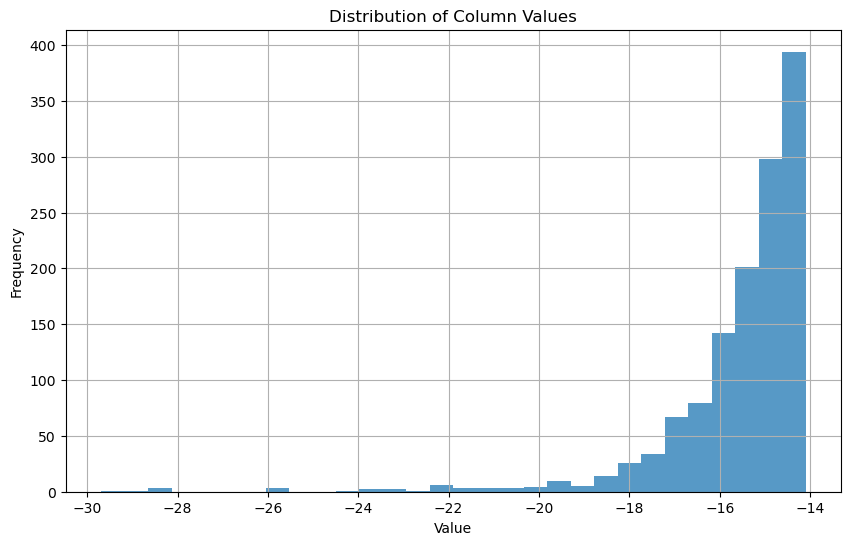

In [119]:
# Plotting the distribution using a histogram
plt.figure(figsize=(10, 6))
plt.hist(df[df.score_category == 'Very Strong'].score1, bins=30, alpha=0.75)
plt.title('Distribution of Column Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [92]:
mean_score + 2*sigma

-1.5902593157757874

In [91]:
mean_score + sigma

-4.716704812449107

In [71]:
print(mean_score - sigma)

-10.969595805795748


In [72]:
print(mean_score + sigma)

-4.716704812449107


In [94]:
df[df.score_category == 'Very Strong'].score1.mean()

-15.526854950115117

In [95]:
df[df.score_category == 'Strong'].score1.mean()

-11.553844695548237

In [96]:
df[df.score_category == 'Medium+'].score1.mean()

-8.967181319688715

In [97]:
df[df.score_category == 'Medium-'].score1.mean()

-6.858874073289629

In [99]:
tensors = {}

for protein in proteins:

    tensors[protein] = load('proteins/embeddings/' + protein + '_embedding.pt')

In [108]:
for key, value in tensors.items():

    print(value.shape)

torch.Size([1, 400, 1280])
torch.Size([1, 1990, 1280])
torch.Size([1, 636, 1280])
torch.Size([1, 1263, 1280])


In [109]:
from torch.nn.functional import pad


In [112]:
max_length = max(tensor.size(1) for tensor in tensors.values())
max_length

1990

### Padding tensors

In [114]:
padded_tensors = {}

for protein, tensor in tensors.items():
    pad_length = max_length - tensor.size(1)
    padded_tensor = pad(tensor, (0, 0, 0, pad_length))  # Padding along the second dimension
    padded_tensors[protein] = padded_tensor

In [116]:
for key, value in padded_tensors.items():

    print(value.shape)

torch.Size([1, 1990, 1280])
torch.Size([1, 1990, 1280])
torch.Size([1, 1990, 1280])
torch.Size([1, 1990, 1280])


In [101]:
proteins = df.protein.tolist()

In [102]:
proteins

['apol1',
 'apol1',
 'scn9a',
 'adcy5',
 'scn9a',
 'apol1',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'scn9a',
 'scn9a',
 'scn9a',
 'apol1',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'adcy5',
 'apol1',
 'scn9a',
 'scn9a',
 'scn9a',
 'scn9a',
 'scn9a',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'apol1',
 'apol1',
 'scn9a',
 'apol1',
 'scn9a',
 'apol1',
 'adcy5',
 'scn9a',
 'apol1',
 'scn9a',
 'scn9a',
 'scn9a',
 'scn9a',
 'scn9a',
 'scn9a',
 'scn9a',
 'scn9a',
 'scn9a',
 'apol1',
 'apol1',
 'apol1',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'apol1',
 'scn9a',
 'scn9a',
 'apol1',
 'apol1',
 'apol1',
 'scn9a',
 'scn9a',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'scn9a',
 'scn9a',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'scn9a',
 'scn9a',
 'apol1',
 'apol1',
 'scn9a',
 'apol1',
 'apol1',
 'apol1',


In [104]:
new_list_of_tensors = [tensors[protein] for protein in proteins]

In [106]:
len(new_list_of_tensors)

3617984

In [117]:
new_list_of_tensors

[tensor([[[ 0.0294, -0.0003,  0.0925,  ..., -0.1806,  0.1562, -0.0058],
          [-0.1946,  0.1738, -0.0511,  ...,  0.1141, -0.0597, -0.0010],
          [-0.1579,  0.0912,  0.0042,  ...,  0.2209,  0.1433,  0.0470],
          ...,
          [-0.0617, -0.0068, -0.0116,  ...,  0.1978,  0.0556,  0.0226],
          [ 0.0489,  0.1007,  0.0295,  ...,  0.0370,  0.2020, -0.1112],
          [-0.0444,  0.0979,  0.0806,  ..., -0.1284,  0.2634, -0.0867]]]),
 tensor([[[ 0.0294, -0.0003,  0.0925,  ..., -0.1806,  0.1562, -0.0058],
          [-0.1946,  0.1738, -0.0511,  ...,  0.1141, -0.0597, -0.0010],
          [-0.1579,  0.0912,  0.0042,  ...,  0.2209,  0.1433,  0.0470],
          ...,
          [-0.0617, -0.0068, -0.0116,  ...,  0.1978,  0.0556,  0.0226],
          [ 0.0489,  0.1007,  0.0295,  ...,  0.0370,  0.2020, -0.1112],
          [-0.0444,  0.0979,  0.0806,  ..., -0.1284,  0.2634, -0.0867]]]),
 tensor([[[ 0.0599,  0.0072,  0.0975,  ..., -0.2745,  0.1429,  0.0200],
          [ 0.0078, -0.1106,

In [120]:
df

,score1,protein,score_category
CHEMBL1431512,-8.346,apol1,Medium+
CHEMBL115889,-8.251,apol1,Medium+
CHEMBL3482603,-7.285,scn9a,Medium-
CHEMBL3769713,-8.272,adcy5,Medium+
CHEMBL228670,-6.745,scn9a,Medium-
...,...,...,...
CHEMBL454427,-7.958,scn9a,Medium+
CHEMBL4933170,-7.914,apol1,Medium+
CHEMBL566870,-6.217,apol1,Medium-
CHEMBL4890125,-6.965,scn9a,Medium-
